NLP Project

In [ ]:
import numpy as np
import pandas as pd
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.svm import SVC
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE 

from nltk.stem.porter import *  
stemmer = PorterStemmer() 
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/winemag-data-130k-v2.csv')


Mounted at /content/drive


In [ ]:

df.head(2)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


In [ ]:
# # Preprocessing

# # Stopwords
# stopwords = set(stopwords.words('english'))

# # Detokenizer to combines tokens together
# detokenizer = TreebankWordDetokenizer()

# # Tokenizer and cleaning function
# def clean_text(description):
#   description = word_tokenize(description.lower())
#   description = [token for token in description if token not in stopwords and token.isalpha()]
#   return detokenizer.detokenize(description)

# Preprocessing

# Stopwords
stopwords = set(stopwords.words('english'))

# Detokenizer to combines tokens together
detokenizer = TreebankWordDetokenizer()

# Tokenizer and cleaning function
def clean_text(description):
  regex = '([A-Za-z]{2,15}){1}(?! /)'            
  description = re.findall(regex, description.lower())
  #description = word_tokenize(words)
  description = [token for token in description if token not in stopwords and token.isalpha()]
  return detokenizer.detokenize(description)



In [ ]:
# Apply Function

df["description"] = df["description"].apply(clean_text)
df.head(2)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,aromas include tropical fruit broom brimstone ...,Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,ripe fruity wine smooth still structured firm ...,Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


# Wine Color Prediction

In [ ]:
df.dropna(subset=["variety"], inplace=True)
# Check for null values in description and points = none
#df.T.apply(lambda x: x.isnull().sum(), axis = 1)

In [ ]:
#'White' in df["variety"][0]

# def wine_color(string):
#   if 'White' in string:
#     word = string.replace(string, "White")
#   elif 'Red' in string:
#     word = string.replace(string, "Red")
#   else:
#     word = string
#   return word



def wine_color(string):
  white_list = ['White', 'Chardonnay', 'Riesling', 'Blanc', 'Veltliner', 'Pinot', 'Grigio', 'Gewürztraminer', 'Viognier', 'Glera', 'Albariño', 'Moscato', 'Sauvignon', 'Verdejo', 'Melon', 'Garganega', 'Torrontés', 'Prosecco', 'Vermentino', 'Roussanne', 'Verdicchio', 'Turbiana', 'Bianco', 'Fiano', 'Vernaccia', 'Grillo', 'Alvarinho', 'Sémillon', 'Muscat', 'Grenache', 'Friulano', 'Greco', 'Viura', 'Sherry', 'Falanghina', 'Ribolla', 'Gialla', 'Arneis', 'Godello', 'Arinto', 'Cortese', 'Verdelho', 'Marsanne']
  red_list = ['Red', 'Noir', 'Cabernet', 'Sauvignon', 'Syrah', 'Merlot', 'Nebbiolo', 'Zinfandel', 'Sangiovese', 'Malbec', 'Tempranillo', 'Gris', 'Cabernet', 'Franc', 'Gamay', 'Shiraz', "Petite", "Sirah", "Sangiovese", "Grosso", "Barbera", "Port", "Grenache", "Corvina", "Rondinella", "Molinara", "Tempranillo", "Carmenère", "Nero", "d'Avola", "Aglianico", "Garnacha", "Verdot", "Blaufränkisch", "Mourvèdre", "Primitivo", "Montepulciano", "Zweigelt", "Nacional", "Nero", "G-S-M", "Dolcetto", "Tannat", "Mencía", "Toro", "Monastrell", "Pinotage", "Nerello", "Sauvignon-Merlot", "Bonarda", "Sagrantino", "Sauvignon-Syrah", "Fino", "Malbec-Merlot", "Laurent", "Negroamaro", "Lagrein", "Cabernet", "Carignan", "Spätburgunder", "red", "Agiorgitiko"]
  slist = string.split()

  if any(item in white_list for item in slist):
    word = string.replace(string, "White")
  elif any(item in red_list for item in slist):
    word = string.replace(string, "Red")
  else:
    word = string
  return word


In [ ]:
df["description"]

0         aromas include tropical fruit broom brimstone ...
1         ripe fruity wine smooth still structured firm ...
2         tart snappy flavors lime flesh rind dominate g...
3         pineapple rind lemon pith orange blossom start...
4         much like regular bottling comes across rather...
                                ...                        
129966    notes honeysuckle cantaloupe sweeten delicious...
129967    citation given much decade bottle age prior re...
129968    well drained gravel soil gives wine crisp dry ...
129969    dry style pinot gris crisp acidity also weight...
129970    big rich dry powered intense spiciness rounded...
Name: description, Length: 129970, dtype: object

In [ ]:
#df["variety"] = df["variety"].apply(wine_color)
df["variety"]= df["variety"].apply(lambda x: wine_color(x))
#new_df = pd.DataFrame([df["description"], df["variety"]])
df.head(100)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,aromas include tropical fruit broom brimstone ...,Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White,Nicosia
1,1,Portugal,ripe fruity wine smooth still structured firm ...,Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Red,Quinta dos Avidagos
2,2,US,tart snappy flavors lime flesh rind dominate g...,NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),White,Rainstorm
3,3,US,pineapple rind lemon pith orange blossom start...,Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,White,St. Julian
4,4,US,much like regular bottling comes across rather...,Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,White,Sweet Cheeks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,France,dense wine packed tannins acidity brings agewo...,NaN,88,20.0,Beaujolais,Juliénas,NaN,Roger Voss,@vossroger,Henry Fessy 2015 Juliénas,Red,Henry Fessy
96,96,France,wine comes one cru estates followed negociant ...,NaN,88,18.0,Beaujolais,Régnié,NaN,Roger Voss,@vossroger,Henry Fessy 2015 Régnié,Red,Henry Fessy
97,97,US,wisp bramble extends savory tone nose finish o...,Ingle Vineyard,88,20.0,New York,Finger Lakes,Finger Lakes,Anna Lee C. Iijima,NaN,Heron Hill 2015 Ingle Vineyard Riesling (Finge...,White,Heron Hill
98,98,Italy,forest floor menthol espresso cranberry presse...,Dono Riserva,88,30.0,Tuscany,Morellino di Scansano,NaN,Kerin O’Keefe,@kerinokeefe,Serpaia di Endrizzi 2010 Dono Riserva (Morell...,Red,Serpaia di Endrizzi


In [ ]:
# Check the varoty counts (We have to get rid of all the other categories and leave only Red and White wines)
df.groupby(df['variety']).size()

variety
Abouriou                   3
Aidani                     1
Airen                      3
Albana                    23
Albanello                  1
                          ..
Zierfandler               16
Zierfandler-Rotgipfler     5
Zlahtina                   2
Çalkarası                  2
Žilavka                    1
Length: 486, dtype: int64

In [ ]:
# Create new dataframe
new_df = df[(df['variety']=='Red') | (df['variety']=='White')]
df.groupby(new_df['variety']).size()

variety
Red      53335
White    64430
dtype: int64

In [ ]:
red_count = len(df[df['variety']=='Red'])
white_count = len(df[df['variety']=='White'])
# len(df) - (red_count+white_count)
white_count

64430

In [ ]:
# Bar Graph
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('seaborn')

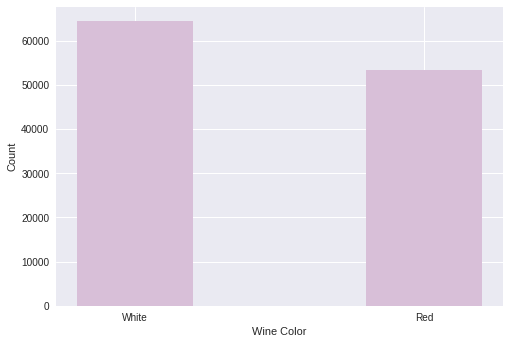

In [ ]:
accs = [white_count, red_count]
models = ["White", "Red"]
plt.bar(models, accs, width = 0.4, color = 'thistle')
plt.xlabel("Wine Color")
plt.ylabel("Count")
# plt.title("Students enrolled in different courses")
plt.show()

In [ ]:
# Select only relevant columns
new_df = new_df[["description", "variety"]]
new_df.head(2)

,description,variety
0,aromas include tropical fruit broom brimstone ...,1
1,ripe fruity wine smooth still structured firm ...,0


In [ ]:
# Preprocessing
def get_vector_feature_matrix(description):
    vectorizer = CountVectorizer(lowercase=True, stop_words="english", max_features=700) 
    vector = vectorizer.fit_transform(description)
    return vector, vectorizer

vector, vectorizer = get_vector_feature_matrix(new_df['description'])

In [ ]:
print(vectorizer.get_feature_names())

['accent', 'accented', 'accents', 'accessible', 'acid', 'acidic', 'acidity', 'acids', 'add', 'adding', 'adds', 'aftertaste', 'age', 'aged', 'aging', 'alcohol', 'almond', 'alongside', 'ample', 'anise', 'appeal', 'appealing', 'appellation', 'apple', 'apples', 'approachable', 'apricot', 'aroma', 'aromas', 'aromatic', 'asian', 'assertive', 'astringent', 'attractive', 'austere', 'away', 'backbone', 'backed', 'background', 'bacon', 'baked', 'baking', 'balance', 'balanced', 'balsamic', 'banana', 'barrel', 'barrels', 'based', 'basic', 'bean', 'beautiful', 'beautifully', 'beef', 'berries', 'berry', 'best', 'better', 'big', 'bit', 'bite', 'bitter', 'bitterness', 'black', 'blackberries', 'blackberry', 'blanc', 'blend', 'blended', 'blossom', 'blue', 'blueberry', 'boasts', 'bodied', 'body', 'bold', 'bone', 'bordeaux', 'bottle', 'bottling', 'bouquet', 'boysenberry', 'bracing', 'brambly', 'bright', 'bring', 'brings', 'briny', 'brisk', 'broad', 'brooding', 'brown', 'burnt', 'butter', 'buttered', 'butt

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
new_df['variety'] = labelencoder.fit_transform(new_df['variety'])

features=vector.todense()
label = new_df['variety']

In [ ]:


df_white=new_df[new_df["variety"] == 1]

df_red= new_df[new_df["variety"]== 0]
df_red.head(4)


,description,variety
1,ripe fruity wine smooth still structured firm ...,0
13,dominated oak oak driven aromas include roaste...,0
16,baked plum molasses balsamic vinegar cheesy oa...,0
17,raw black cherry aromas direct simple good jui...,0


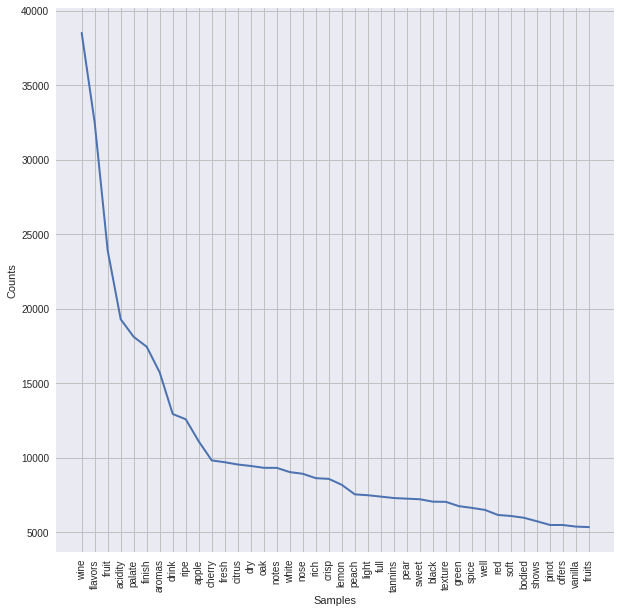

In [ ]:
#wordcloud for white blends
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist

text = " ".join(review for review in df_white.description)
#print ("There are {} words in the combination of all review.".format(len(text)))

tokenizer = RegexpTokenizer(r'\w+')
tokens = tokenizer.tokenize(text)

plt.figure(figsize=(10, 10))
freq = FreqDist(tokens)
freq.plot(40)

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

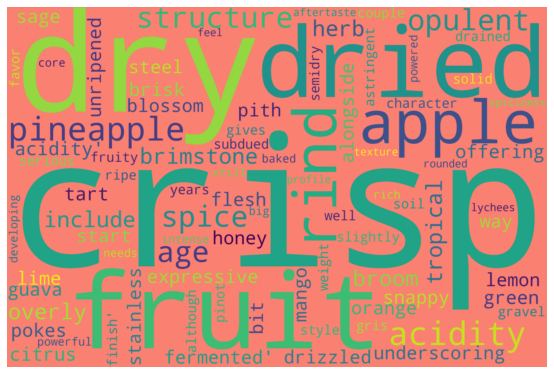

In [ ]:
#Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["wine", "flavors","notes","finish","palate","drink'","aromas","drink","giving","dominate"])
text = df_white.description.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color='salmon',
    stopwords = stopwords).generate(str(text))
fig = plt.figure(
    figsize = (10, 5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()




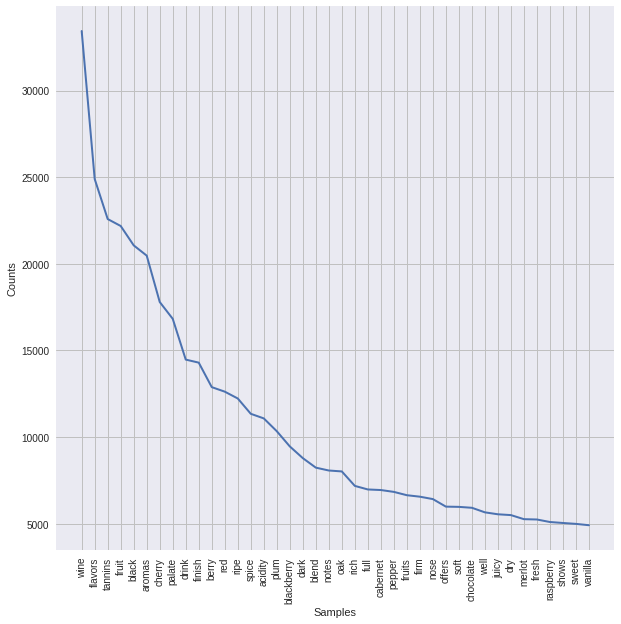

In [ ]:
#wordcloud for red blends
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist

text = " ".join(review for review in df_red.description)
#print ("There are {} words in the combination of all review.".format(len(text)))

tokenizer = RegexpTokenizer(r'\w+')
tokens = tokenizer.tokenize(text)

plt.figure(figsize=(10, 10))
freq = FreqDist(tokens)
freq.plot(40)

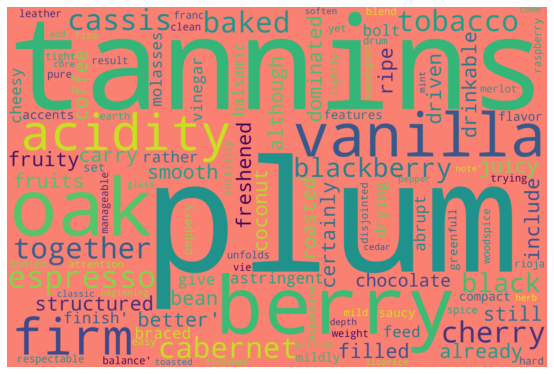

In [ ]:
#Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["wine", "flavors","notes","finish","palate","drink'","drink","aromas","red"])
text2 = df_red.description.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color='salmon',
    stopwords = stopwords).generate(str(text2))
fig = plt.figure(
    figsize = (10, 5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()



In [ ]:
# new_df['points'].value_counts()
label.value_counts()

1    64430
0    53335
Name: variety, dtype: int64

In [ ]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3)
y_train.value_counts()


1    45112
0    37323
Name: variety, dtype: int64

# Logistic Regression

In [ ]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report  

In [ ]:
lr = LogisticRegression(multi_class='multinomial',solver='lbfgs')
lr_model = lr.fit(X_train, y_train)
pred_lr = lr_model.predict(X_test)


report_lr = classification_report(y_test, pred_lr, output_dict=True)
df_lr = pd.DataFrame(report_lr).transpose().round(4)
df_lr

,precision,recall,f1-score,support
0,0.8353,0.8915,0.8625,16012.0000
1,0.9047,0.8543,0.8788,19318.0000
accuracy,0.8711,0.8711,0.8711,0.8711
macro avg,0.8700,0.8729,0.8706,35330.0000
weighted avg,0.8732,0.8711,0.8714,35330.0000


In [ ]:
acc_lr = accuracy_score(y_test, pred_lr)
print(acc_lr)

0.8711293518256439


# Decision Tree

In [ ]:
d_tree = tree.DecisionTreeClassifier()
model_tree = d_tree.fit(X_train, y_train)


In [ ]:
tree = DecisionTreeClassifier()
tree_model=tree.fit(X_train, y_train)
pred_tree = tree_model.predict(X_test)

report_tree = classification_report(y_test, pred_tree, output_dict=True)
df_tree = pd.DataFrame(report_tree).transpose().round(4)
df_tree

,precision,recall,f1-score,support
0,0.8218,0.8225,0.8221,16012.0000
1,0.8528,0.8522,0.8525,19318.0000
accuracy,0.8387,0.8387,0.8387,0.8387
macro avg,0.8373,0.8373,0.8373,35330.0000
weighted avg,0.8387,0.8387,0.8387,35330.0000


In [ ]:
acc_d = accuracy_score(y_test, pred_tree)
print(acc_d)

0.8387206340220775


# Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=0)
model_rf = rf.fit(X_train, y_train)

In [ ]:
rf = RandomForestClassifier(n_estimators=400)
rf_model=rf.fit(X_train, y_train)
pred_rf = rf_model.predict(X_test)


report_rf = classification_report(y_test, pred_rf, output_dict=True)
df_rf = pd.DataFrame(report_rf).transpose().round(4)
df_rf

,precision,recall,f1-score,support
0,0.8401,0.9348,0.8849,16012.0000
1,0.9404,0.8526,0.8943,19318.0000
accuracy,0.8898,0.8898,0.8898,0.8898
macro avg,0.8903,0.8937,0.8896,35330.0000
weighted avg,0.8950,0.8898,0.8901,35330.0000


In [ ]:
acc_rf = accuracy_score(y_test, pred_rf)
print(acc_rf)

0.889838664024908


In [ ]:
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('seaborn')

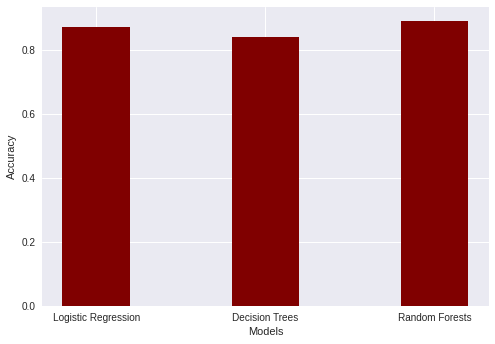

In [ ]:
accs = [acc_lr, acc_d, acc_rf]
models = ["Logistic Regression", "Decision Trees", "Random Forests"]
plt.bar(models, accs, width = 0.4, color='maroon')
plt.xlabel("Models")
plt.ylabel("Accuracy")
# plt.title("Students enrolled in different courses")
plt.show()